# Reading 4 ECG Signals

In [4]:
import wfdb
import os

data_path = 'C:\\Users\\DELL\\Desktop\\HCI-data\\'

ecg_signals =[]
ecg_fields = []

for subject in os.listdir(data_path):
    for x in os.listdir(data_path + subject):
        print(data_path + subject + '\\' + x.split('.')[0])
        signal, fields = wfdb.rdsamp(data_path + subject + '\\' + x.split('.')[0], channels=[1])
        ecg_signals.append(signal)
        ecg_fields.append(fields)
        break
        

len(ecg_signals[0])

C:\Users\DELL\Desktop\HCI-data\Patient - 214\s0436_re
C:\Users\DELL\Desktop\HCI-data\Patient - 237\s0465_re
C:\Users\DELL\Desktop\HCI-data\Patient - 238\s0466_re
C:\Users\DELL\Desktop\HCI-data\Patient - 260\s0496_re


120012

### Plotting each signal

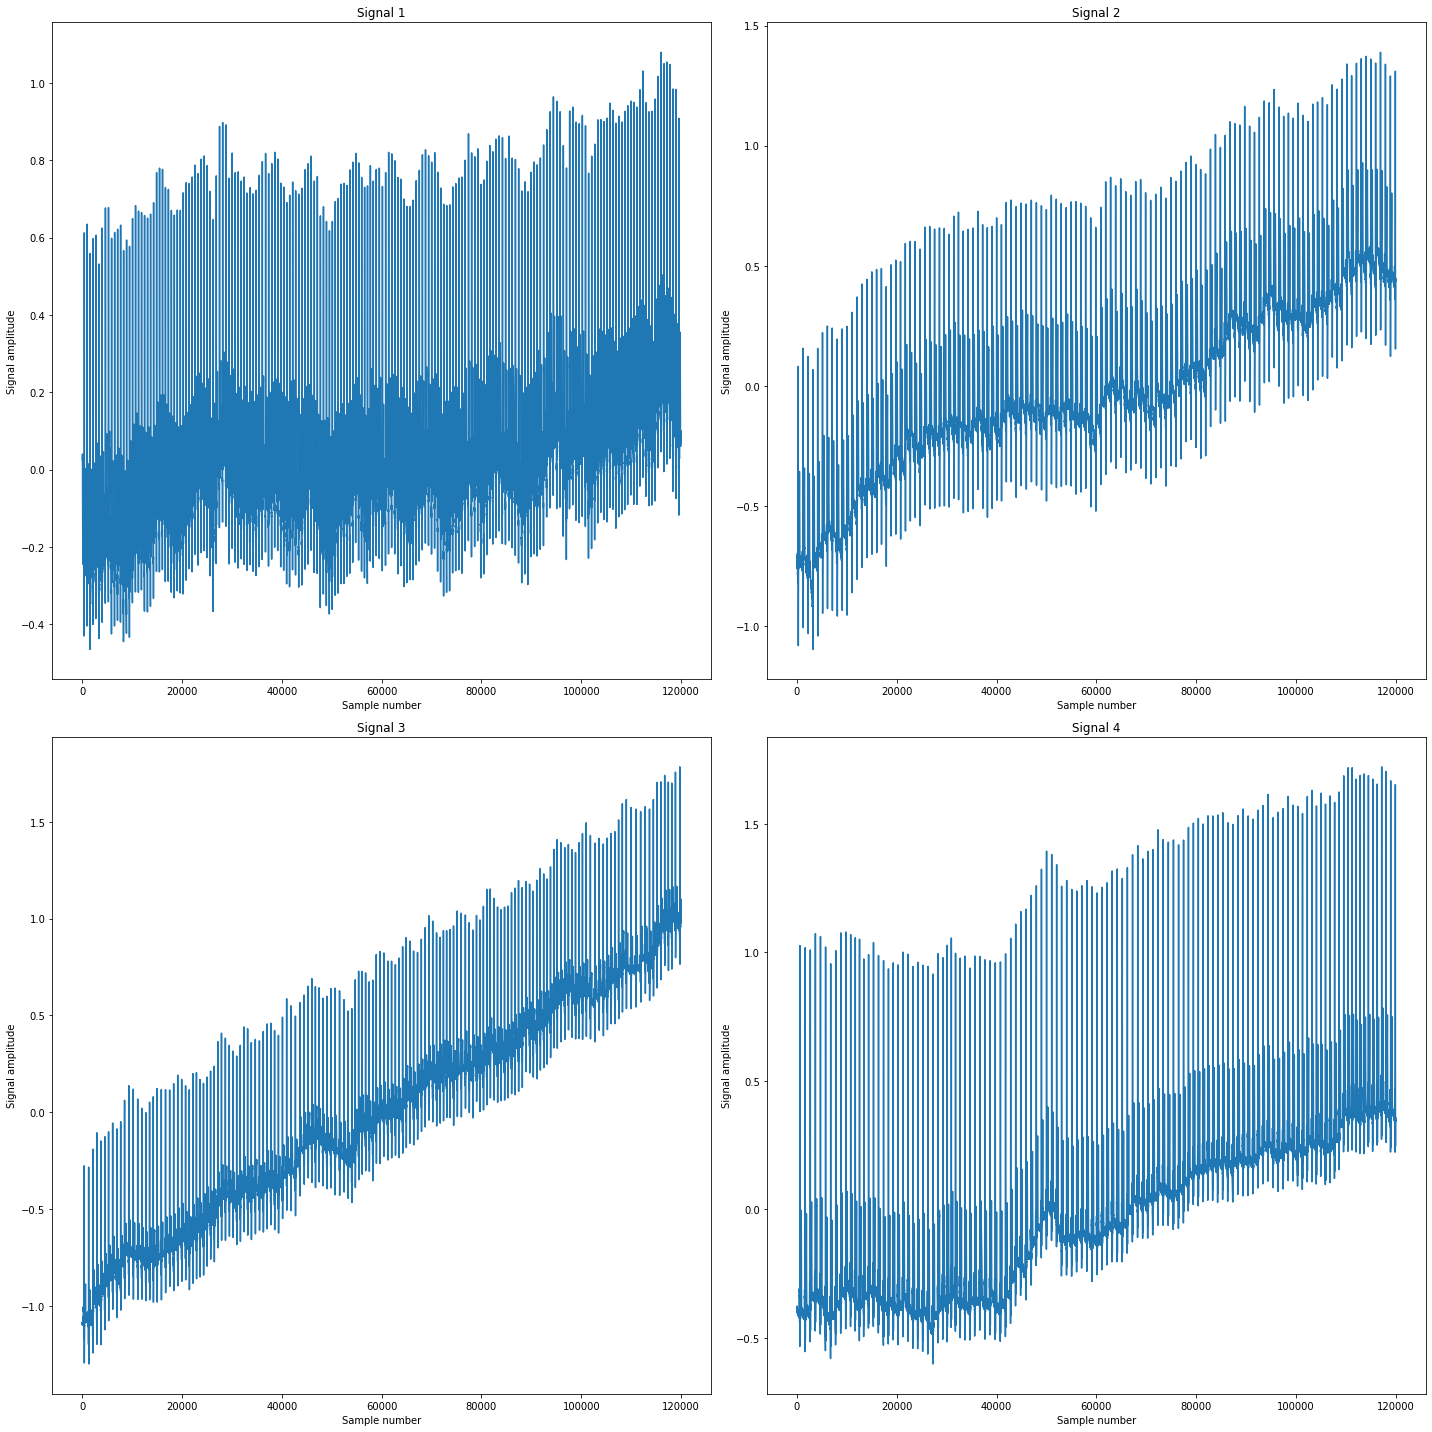

In [5]:
import matplotlib.pyplot as plt

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(20, 20))
# Plot each ECG signal on a separate subplot
for i in range(4):
    row = i // 2
    col = i % 2
    axs[row, col].plot(ecg_signals[i])
    axs[row, col].set_xlabel('Sample number')
    axs[row, col].set_ylabel('Signal amplitude')
    axs[row, col].set_title(f'Signal {i+1}')

# Adjust subplot spacing and display the plot
plt.tight_layout()
plt.show()


### Plotting 1.5 sec from each signal

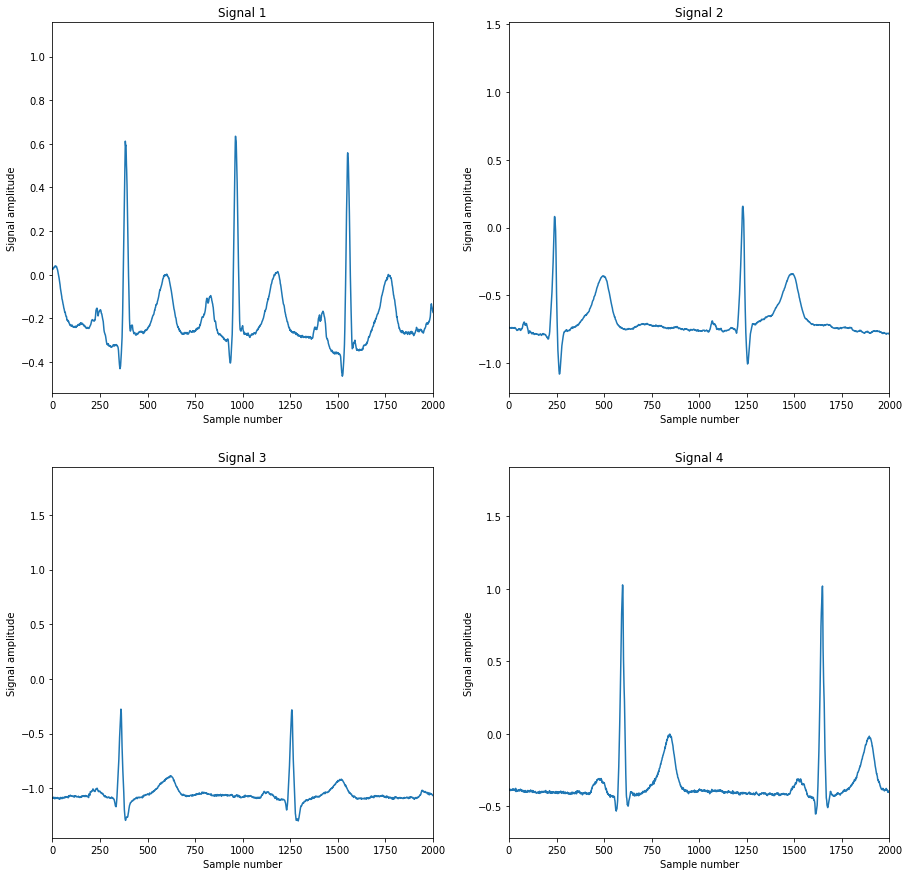

In [6]:
start_sec = 0
end_sec = 2

fig, axs = plt.subplots(2, 2, figsize=(15, 15))


for i in range(4):
    fs = ecg_fields[i]['fs']
    start_sample = int(start_sec * fs)
    end_sample = int(end_sec * fs)
    row = i // 2
    col = i % 2
    
    axs[row, col].plot(ecg_signals[i])
    axs[row, col].set_xlabel('Sample number')
    axs[row, col].set_ylabel('Signal amplitude')
    axs[row, col].set_title(f'Signal {i+1}')
    axs[row, col].set_xlim([start_sample, end_sample])

plt.show()

# Preprocessing

### bandpass filter

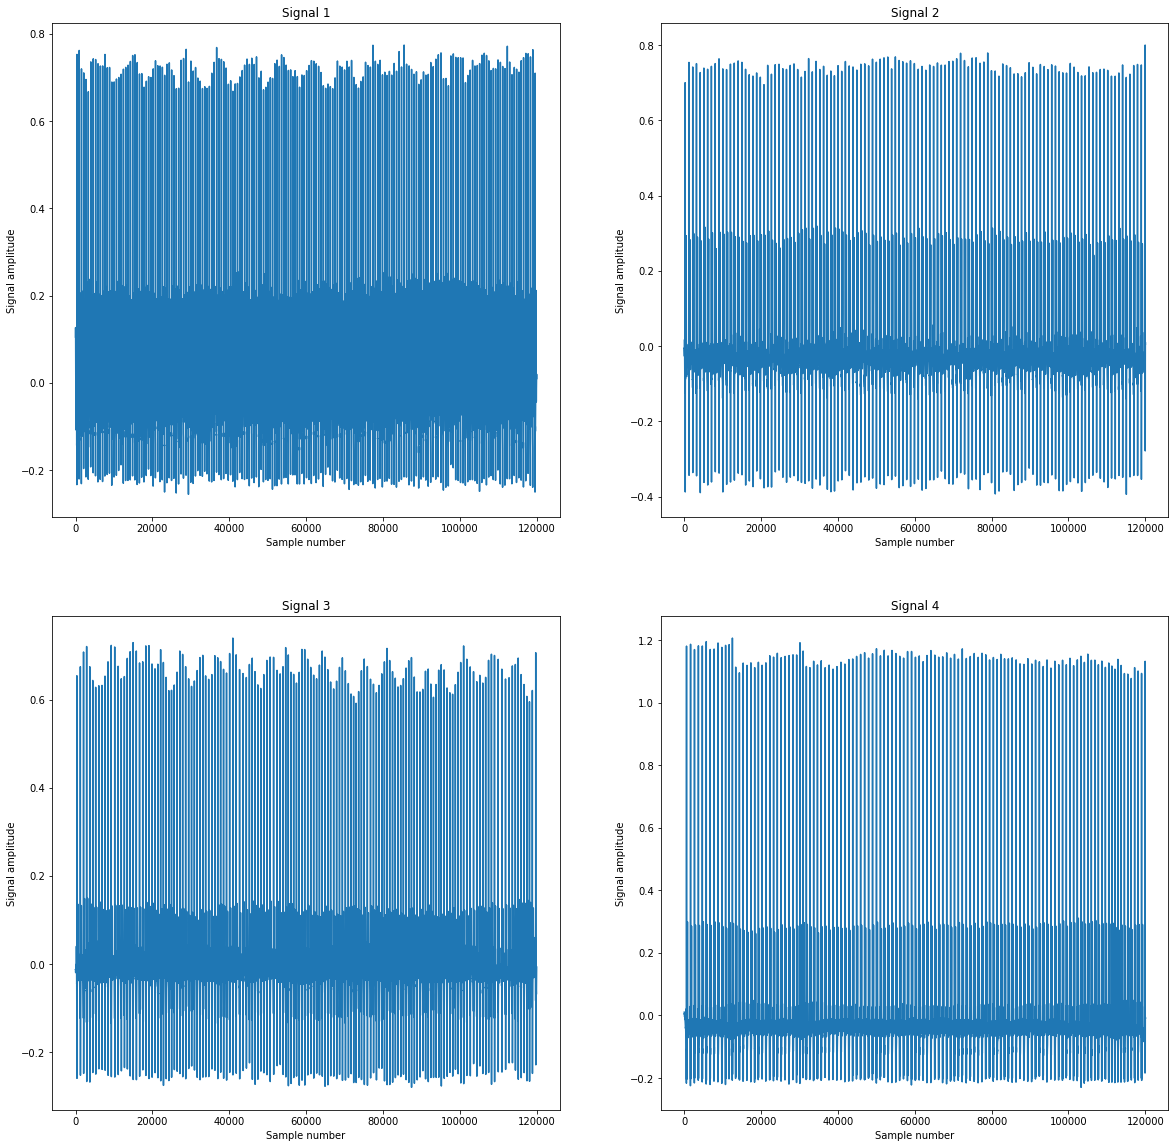

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, filtfilt, find_peaks

filtered_signals = []

# Define bandpass filter parameters
lowcut = 1.0
highcut = 40.0
order = 2

# Apply bandpass filter to the signal
for i in range(4):
    fs = ecg_fields[i]['fs']
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    filtered = filtfilt(b, a, ecg_signals[i][:, 0])
    filtered_signals.append(filtered)


fig, axs = plt.subplots(2, 2, figsize=(20, 20))
for i in range(4):
    row = i // 2
    col = i % 2
    axs[row, col].plot(filtered_signals[i])
    axs[row, col].set_xlabel('Sample number')
    axs[row, col].set_ylabel('Signal amplitude')
    axs[row, col].set_title(f'Signal {i+1}')

plt.show()

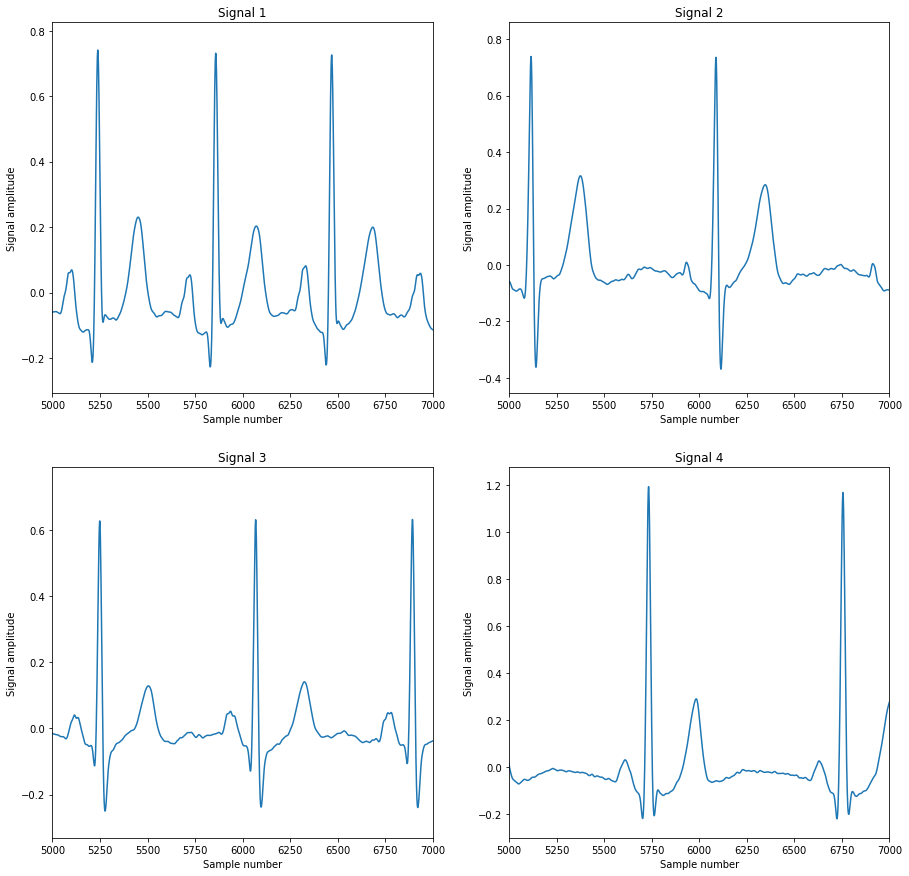

In [8]:
start_sec = 5
end_sec = 7

fig, axs = plt.subplots(2, 2, figsize=(15, 15))


for i in range(4):
    fs = ecg_fields[i]['fs']
    start_sample = int(start_sec * fs)
    end_sample = int(end_sec * fs)
    row = i // 2
    col = i % 2
    
    axs[row, col].plot(filtered_signals[i])
    axs[row, col].set_xlabel('Sample number')
    axs[row, col].set_ylabel('Signal amplitude')
    axs[row, col].set_title(f'Signal {i+1}')
    axs[row, col].set_xlim([start_sample, end_sample])

plt.show()

### Segmentation

In [9]:
import numpy as np

# Define the segment length and overlap (in samples)
segment_len = 2000
overlap = 200

# Create an empty list to store the segments
segment_list = []
segment_class = []

# Loop over each ECG signal in the 'ecg_signals' list
for i in range(len(filtered_signals)):
    
    # Calculate the total number of segments in the signal
    num_segments = int(np.ceil((len(filtered_signals[i]) - segment_len) / overlap)) + 1
    
    # Loop over each segment in the signal
    for j in range(num_segments):
        
        # Calculate the start and end indices of the current segment
        start = j * overlap
        end = start + segment_len
        
        # Make sure the segment doesn't exceed the length of the signal
        if end > len(filtered_signals[i]):
            end = len(filtered_signals[i])
            start = end - segment_len
        
        # Extract the current segment from the signal
        segment = filtered_signals[i][start:end]
        
        # Append the segment to the segment list
        segment_list.append(segment)
        segment_class.append(i)

Non-Fiducial Features (AC / DCT)

In [32]:
segs = np.array(segment_list)
segs = np.squeeze(segs)
print(segs.shape)

segment_class = np.array(segment_class)

(2368, 2000)


In [11]:
import statsmodels.api as sm
import scipy
features1 = []
for i in range(len(segs)):
    acf = sm.tsa.acf(segs[i],nlags=2000)
    features1.append(scipy.fftpack.dct(acf[0:400], type=2)) 
    

c:\users\dell\anaconda3\envs\nlp\lib\site-packages\statsmodels\tsa\stattools.py:671: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


In [12]:
features1 = np.array(features1)
features1.shape

(2368, 400)

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features1, segment_class, test_size=0.2,shuffle=True)

In [14]:
from sklearn.linear_model import LogisticRegression

logistic_classifier = LogisticRegression()
logistic_classifier.fit(X_train, y_train)

c:\users\dell\anaconda3\envs\nlp\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

In [15]:
y_pred = logistic_classifier.predict(X_test)

In [16]:
from sklearn import metrics

acc = metrics.accuracy_score(y_test,y_pred)


In [17]:
acc

1.0

Non-Fiducial Features (Wavelets)

In [18]:
segs = np.array(segment_list)
segs = np.squeeze(segs)

segment_class = np.array(segment_class)


In [19]:
from pywt import wavedec
import pywt

features2 = []

for i in range(len(segs)):
    coeffs = pywt.wavedec(segs[i], 'db4', level = 4)
    features2.append(coeffs[0])
print(len(features2))
print(len(features2[0]))
print(features2[0])

2368
131
[ 0.43304343  0.43271835  0.43130343  0.43429045  0.42426015  0.46100749
  0.50218815  0.2606178  -0.07005972 -0.282249   -0.39525627 -0.43100074
 -0.42331849 -0.36974728 -0.30966413 -0.31719936 -0.35212389 -0.27133455
 -0.17810537 -0.02786319  0.05061193 -0.05695842 -0.39034258 -0.54877555
 -0.57608838 -0.52067877 -0.57717761 -1.08405618  1.50002386  2.47552499
  0.18564733 -0.25625732 -0.32624208 -0.29788046 -0.2962218  -0.28352451
 -0.22805626 -0.11515838  0.05068481  0.2309845   0.45166631  0.66715626
  0.75167257  0.65130174  0.33743997 -0.00328151 -0.22570237 -0.32537567
 -0.33629718 -0.33455654 -0.30940115 -0.30230935 -0.27771211 -0.19872711
 -0.07248621  0.14500036  0.30240529  0.25498123 -0.09475316 -0.32576484
 -0.38974969 -0.4585582  -0.4310401  -1.05428682  0.83625625  2.78932281
  0.43831945 -0.30510828 -0.35602683 -0.39387602 -0.3858818  -0.35623563
 -0.28551288 -0.19654967 -0.04408478  0.16712164  0.42138657  0.66211899
  0.80518264  0.77673225  0.45952185  0.14

In [20]:
features2 = np.array(features2)
features2.shape

(2368, 131)

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features2, segment_class, test_size=0.2,shuffle=True)

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn import svm

logistic_classifier = LogisticRegression()
logistic_classifier.fit(X_train, y_train)

c:\users\dell\anaconda3\envs\nlp\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

In [23]:
y_pred = logistic_classifier.predict(X_test)

from sklearn import metrics

acc = metrics.accuracy_score(y_test,y_pred)

acc

0.27637130801687765

# Fiducial Features

In [24]:
import wfdb
import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

R_indices = []

for i in range (4):
    peaks, _ = find_peaks(filtered_signals[i], distance=550)
    R_indices.append(peaks)


In [25]:
S_indices = []
fs = 1000
for i in range(4):
    s_idx = []
    for r_peak in R_indices[i]:
        # Find the minimum value in a small window after the R-peak
        window_size = int(0.04 * fs)
        local_min_index = np.argmin(filtered_signals[i][r_peak:r_peak+window_size])
        s_idx.append(r_peak + local_min_index)
    S_indices.append(s_idx)

In [26]:
Q_indices = []
fs = 1000
for i in range(4):
    q_idx = []
    for r_peak in R_indices[i]:
        window_size = int(0.1 * fs)
        start = r_peak - window_size
        if start < 0:
            start = 0
        local_min_index = np.argmin(filtered_signals[i][start:r_peak -1])
        q_idx.append(start + local_min_index)
    Q_indices.append(q_idx)

In [27]:
T_indices = []
fs = 1000
for i in range(4):
    t_idx = []
    for r_peak in R_indices[i]:
        window_size = int(0.4 * fs)
        local_max_index = np.argmax(filtered_signals[i][r_peak + 40:r_peak+ 40 + window_size])
        t_idx.append(r_peak + 40 + local_max_index)
    T_indices.append(t_idx)

In [28]:
P_indices = []
fs = 1000
for i in range(4):
    p_idx = []
    for r_peak in R_indices[i]:
        window_size = int(0.2 * fs)
        start = r_peak - window_size - 40
        if start < 0:
            start = 0
        local_max_index = np.argmax(filtered_signals[i][start:r_peak -40])
        p_idx.append(start + local_max_index)
    P_indices.append(p_idx)

In [29]:
features3 = []
beats_classes = []
fs = 1000.0
for i in range(4):
    for j in range(len(P_indices[i])):
        QT_duration = (T_indices[i][j]  - Q_indices[i][j]) / fs
        PQ_duration = ((Q_indices[i][j] - P_indices[i][j]) / fs) / QT_duration
        PR_duration = ((R_indices[i][j] - P_indices[i][j]) / fs) / QT_duration
        PS_duration = ((S_indices[i][j] - P_indices[i][j]) / fs) / QT_duration
        PT_duration = ((T_indices[i][j] - P_indices[i][j]) / fs) / QT_duration
        QS_duration = ((S_indices[i][j] - Q_indices[i][j]) / fs) / QT_duration
        QR_duration = ((R_indices[i][j] - Q_indices[i][j]) / fs) / QT_duration
        RS_duration = ((S_indices[i][j] - R_indices[i][j]) / fs) / QT_duration
        RT_duration = ((T_indices[i][j] - R_indices[i][j]) / fs) / QT_duration
        RP_freq = (filtered_signals[i][R_indices[i][j]] - filtered_signals[i][P_indices[i][j]])
        RT_freq = (filtered_signals[i][R_indices[i][j]] - filtered_signals[i][T_indices[i][j]])
        TP_freq = (filtered_signals[i][T_indices[i][j]] - filtered_signals[i][P_indices[i][j]])
        heart_beat_features = [QT_duration, PQ_duration, PR_duration, PS_duration,
                               PT_duration, QS_duration, QR_duration, RS_duration, RT_duration,
                               RP_freq, RT_freq, TP_freq ]
        features3.append(heart_beat_features)
        beats_classes.append(i)


print(len(features3))
features3 = np.array(features3)
beats_classes = np.array(beats_classes)

features3.shape
beats_classes.shape

600


(600,)

In [30]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features3, beats_classes, test_size=0.2,shuffle=True)

from sklearn.linear_model import LogisticRegression
from sklearn import svm

logistic_classifier = LogisticRegression()
logistic_classifier.fit(X_train, y_train)

y_pred = logistic_classifier.predict(X_test)

from sklearn import metrics

acc3 = metrics.accuracy_score(y_test,y_pred)

acc3

c:\users\dell\anaconda3\envs\nlp\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.9916666666666667

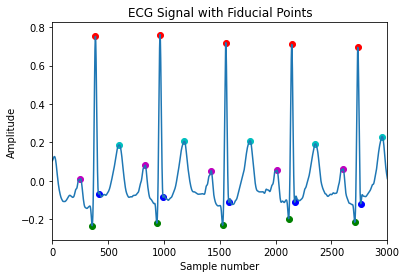

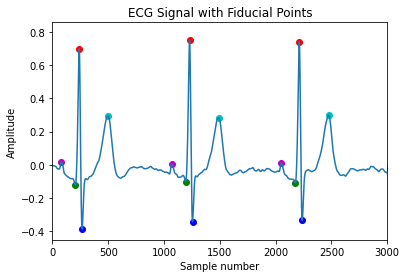

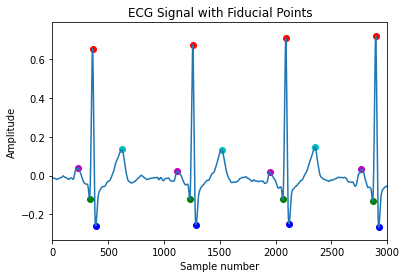

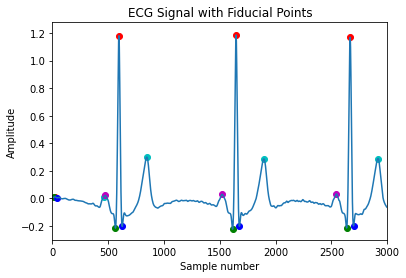

In [31]:
for i in range(4):
    plt.plot(filtered_signals[i])
    plt.scatter(R_indices[i], filtered_signals[i][R_indices[i]], c='r')
    plt.scatter(Q_indices[i], filtered_signals[i][Q_indices[i]], c='g')
    plt.scatter(S_indices[i], filtered_signals[i][S_indices[i]], c='b')
    plt.scatter(T_indices[i], filtered_signals[i][T_indices[i]], c='c')
    plt.scatter(P_indices[i], filtered_signals[i][P_indices[i]], c='m')




    
    plt.xlabel('Sample number')
    plt.ylabel('Amplitude')
    plt.xlim(0, 3000)
    plt.title('ECG Signal with Fiducial Points')
    plt.show()